In [1]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [2]:
source_folder = '/scratche/home/apoorv/freebase/fbwq_half_lego_processed'
! ls {source_folder}

test.txt  train.txt  valid.txt


In [3]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

def getEntities(triples):
    ents = set()
    for t in triples:
        ents.add(t[0])
        ents.add(t[2])
    return ents

def getRelations(triples):
    rels = set()
    for t in triples:
        rels.add(t[1])
    return rels


In [4]:
# load half data
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [5]:
entities = set()
relations = set()
for split in splits:
    e = getEntities(data[split])
    entities = entities.union(e)
    r = getRelations(data[split])
    relations = relations.union(r)
len(entities), len(relations)

(158674, 816)

In [6]:
data['train'][5000]

['m.0g_r22', 'topic_server.population_number', '"168"']

In [8]:
from unidecode import unidecode
# lowering everything

def normalizeRelation(rel):
#     rel = rel.replace('_', ' ')
    rel = unidecode(rel)
    rel = rel.split('.')[-1]
    rel = rel.replace('_', ' ')
    rel = rel.replace('|', ',')
    rel = rel.lower()
    return rel

def normalizeEntity(ent):
    ent = unidecode(ent)
    ent = ent.replace('|', '')
    ent = ent.lower()
    return ent


def getBestName(names, max_words = 5):
    best_name = names[0]
    for name in names:
        if name.endswith('@en'):
            best_name = name
    name = best_name.replace('"', '')
    name = name.split('@')[0]
    name = normalizeEntity(name)
#     name = name[:max_len]
    name = ' '.join(name.split()[:max_words])
    return name

def getBestDescription(descriptions, max_description_words=8):
    best_desc = descriptions[0]
    for desc in descriptions:
        if desc.endswith('@en'):
            best_desc = desc
    desc = best_desc
    desc = (''.join(desc.split('@')[:-1])).replace('"', '')
    desc = ' '.join(desc.split()[:max_description_words])
    # unidecode stuff
    desc = normalizeEntity(desc)
    return desc

def addDescriptionToName(name, desc):
    desc = desc.replace(name, 'it')
    desc = desc.replace('it is a ', '')
    desc = desc.replace('it was a ', '')
    desc = desc.replace('it was an ', '')
    desc = desc.replace('it is an ', '')
    desc = desc.replace('it is the ', '')
    desc = desc.replace('it was the ', '')
    desc = desc.replace('.', '')
    name = name + ' (' + desc + ')'
    return name

def truncateWords(name, num_words):
    name = name.split()[:num_words]
    name = ' '.join(name)
    return name

In [88]:
import pickle
from tqdm import tqdm
aliases_dict = {}
count = 0
fname = '/scratche/home/apoorv/freebase/ent_identifiers_fbwq_half_lego.pickle'
x = pickle.load(open(fname, 'rb'))
descriptions = {}

In [89]:
len(entities)

158674

In [90]:
max_name_words = 12
for ent in tqdm(entities):
    if ent not in x:
        aliases_dict[ent] = getBestName([ent]) # to unidecode basically
        continue
    reldict = x[ent]
    if 'type.object.name' in reldict.keys():
        names = reldict['type.object.name']
        name = getBestName(names, max_name_words)
        aliases_dict[ent] = name
    elif 'common.topic.description' in reldict.keys():
        descs = reldict['common.topic.description']
        name = getBestName(descs)
        aliases_dict[ent] = name
    elif 'common.topic.alias' in reldict.keys():
        als = reldict['common.topic.alias']
        name = getBestName(als)
        aliases_dict[ent] = name
    else:
        aliases_dict[ent] = getBestName([ent])
        count += 1
    if 'common.topic.description' in reldict.keys():
        descriptions[ent] = reldict['common.topic.description']

100%|██████████████████████████████████████████████████████| 158674/158674 [00:00<00:00, 170850.12it/s]


In [91]:
i = 0
count = 0
for k, v in aliases_dict.items():
    if (v.startswith('g.') or v.startswith('m.')) and ' ' not in v:
#         print(k, v)
        count += 1
#     if count > 100:
#         break
count

14050

In [92]:
len(aliases_dict)

158674

In [93]:
for k, v in tqdm(aliases_dict.items()):
    if v == 'andante':
        print(k)

100%|█████████████████████████████████████████████████████| 158674/158674 [00:00<00:00, 1977680.29it/s]

m.0pd1m03


In [94]:
import random
random.sample(list(aliases_dict.values()), 10)

['148042',
 'tsakhur language',
 'berdosso',
 'gardabaer',
 '2497',
 'm.05ktzbp',
 '784376',
 '31948',
 'deanna edgerson',
 '1671']

In [95]:
import pickle
from unidecode import unidecode
relation_map = {}
fname = '/scratche/home/apoorv/freebase/relation_names_from_google.pickle'
relation_names_from_google = pickle.load(open(fname, 'rb'))
for rel in relations:
    rel_processed = relation_names_from_google[rel]
    rel_processed = unidecode(rel_processed)
    rel_processed = rel_processed.replace('|', ',')
    rel_processed = rel_processed.lower()
    if rel_processed == '':
        print(rel)
    relation_map[rel] = rel_processed

In [96]:
entity_map = {}
for ent in entities:
    val = aliases_dict[ent]
    if val.strip() == '':
        print('here')
        val = ent
    entity_map[ent] = val

In [97]:
len(relation_map), len(set(relation_map.values()))

(816, 650)

In [98]:
len(entity_map), len(set(entity_map.values()))

(158674, 149673)

In [99]:
# don't care about uniqueness, since application is KGQA
# and not KGC
def getUniqueMap(init_map):
    out_map = {}
    aliases_done_reverse_dict = {}
    max_description_words = 8
    for key, value in init_map.items():
        if value not in out_map:
            aliases_done_reverse_dict[value] = key
        else:
            if key in descriptions:
                desc = getBestDescription(descriptions[key], max_description_words)
                # remove name from description, since it will be repeated?
                value = addDescriptionToName(value, desc)
        out_map[key] = value
        
    return out_map

def mapTriple(triple, ent_map, rel_map):
    t = triple
    if t[0] not in ent_map or t[2] not in ent_map:
        print(t)
        return t
    
    new_triple = [ent_map[t[0]], rel_map[t[1]], ent_map[t[2]]]
    return new_triple

In [100]:
uniq_ent_map = getUniqueMap(entity_map)

In [101]:
count = 0
for id in range(500):
    t = mapTriple(data['train'][id], uniq_ent_map, relation_map)
    if 'm.' in t[0] or 'm.' in t[2]:
        count += 1
        print(t)
count

['m.0n5ntbc', 'basic title', 'senator']
['m.05kgzgn', 'officeholder', 'jim bunning']
['chris gray', 'teams', 'm.0hpgr9l']
['m.0wj3mdk', 'governmental body (if position is part of one)', 'rajya sabha']
['m.0h35s2y', 'type of union', 'marriage']
['m.04l4skb', 'office, position, or title', 'governor of indiana']
['confessions of a dangerous mind', 'performances', 'm.0cgbq7z']
['m.0jvy7_z', 'office, position, or title', 'united states representative']
['ted deutch', 'government positions held', 'm.0nbw881']
['m.04ftv07', 'military commander', 'george washington']
['seth macfarlane', 'starring tv roles', 'm.04hbsqv']
['m.04d759g', 'officeholder', 'thomas f. bayard, jr.']
['we were soldiers', 'performances', 'm.0b6spry']
['mike turner', 'government positions held', 'm.0nbwp4f']
['m.04_87vm', 'end date', '0731-02-11']
['m.04jth77', 'jurisdiction of office', 'kentucky']
['united states house of representatives', 'members', 'm.0bw9q1f']
['denver broncos', 'roster', 'm.0hpyfhh']
['m.02vd7w6', 'f

47

In [102]:
import pickle
fname = '../freebase/webqsp_aliases_from_questions.pickle'
webqsp_aliases = pickle.load(open(fname, 'rb'))

In [104]:
count = 0
for key, value in webqsp_aliases.items():
    if key in uniq_ent_map:
        val_from_map = uniq_ent_map[key]
        value = getBestName([value], max_name_words)
#         value = normalizeEntity(value)
        # TODO: we randomly chose 12 words? why 12?
#         value = truncateWords(value, 12)
        if value == '':
            value = key
        if value != val_from_map:
            count += 1
            uniq_ent_map[key] = value
            print(value, val_from_map)
        
#             print(key, '*', value, '*', val_from_map)
count      

8 variations on der dumme gartn: \ein weib ist das herrlichste ding\ 8 variations on der dumme gartn: \"ein weib ist das herrlichste ding\"
siegfried: act ii, scene iii. \willkommen, siegfried!\ siegfried: act ii, scene iii. \"willkommen, siegfried!\"
gotterdammerung: act i, scene ii. \willkommen, gast, in gibichs haus!\ gotterdammerung: act i, scene ii. \"willkommen, gast, in gibichs haus!\"
il sogno di scipione, k. 126: act i recitativo accompagnato \e v'e il sogno di scipione, k. 126: act i recitativo accompagnato \"e v'e
quartet for strings no. 13 in d minor, k. 173 \quartetti vienna\: quartet for strings no. 13 in d minor, k. 173 \"quartetti vienna\":
pantomime, l. 31, cd 47, melodie pour voix et piano \pierrot, qui pantomime, l. 31, cd 47, melodie pour voix et piano \"pierrot, qui
le nozze di figaro, k. 492: act ii, scene ii. recitativo \quante le nozze di figaro, k. 492: act ii, scene ii. recitativo \"quante
die meistersinger von nurnberg: akt iii, szene v. \silentium! silentium

string quartet no. 17 in b-flat major, k. 458 \hunt\: i. allegro string quartet no. 17 in b-flat major, k. 458 \"hunt\": i. allegro
concerto for piano no. 21 in c major, k. 467 \elvira madigan\: concerto for piano no. 21 in c major, k. 467 \"elvira madigan\":
quartet for strings no. 11 in e-flat major, k. 171 \quartetti vienna\: quartet for strings no. 11 in e-flat major, k. 171 \"quartetti vienna\":
march in d major, k. 249 \haffner\ march in d major, k. 249 \"haffner\"
8 variations on der dumme gartn: \ein weib ist das herrlichste ding\ 8 variations on der dumme gartn: \"ein weib ist das herrlichste ding\"
on the set\: behind the scenes \mine\ music video (part 1) on the set\": behind the scenes \"mine\" music video (part 1)
symphony no. 31 in d major, k. 300a/297 \paris\: ii. andante symphony no. 31 in d major, k. 300a/297 \"paris\": ii. andante
quartet for strings no. 14 in g major, k. 387 \haydn quartetti\, quartet for strings no. 14 in g major, k. 387 \"haydn quartetti\",
tristan

quartet for strings no. 7 in e-flat major, k. 159a/160 \quartetti milanesi\: quartet for strings no. 7 in e-flat major, k. 159a/160 \"quartetti milanesi\":
antiphon for soprano, chorus & orchestra in b-flat major, k. 127 \regina antiphon for soprano, chorus & orchestra in b-flat major, k. 127 \"regina
tristan und isolde: adaptation of music from acts ii and iii, \love tristan und isolde: adaptation of music from acts ii and iii, \"love
12 variations on french traditional: \ah, vous dirai-je, maman\ for piano in 12 variations on french traditional: \"ah, vous dirai-je, maman\" for piano in
oratorio in e minor, k. 469 \daviddepenitente\: ix. allegro: trio \tutte le oratorio in e minor, k. 469 \"daviddepenitente\": ix. allegro: trio \"tutte le
andante for piano in b-flat major, k. 15ii/deest \london sketchbook no. 34\ andante for piano in b-flat major, k. 15ii/deest \"london sketchbook no. 34\"
die walkure: act ii, scene iv. \du sahest der walkure sehrenden blick\ die walkure: act ii, sce

1567

In [105]:
len(data['train'])

376359

In [106]:
# save maps
import pickle
fname = 'data/fbwq_full/ent_map_fbwq_half_lego.pickle'
pickle.dump(uniq_ent_map, open(fname, 'wb'))
fname = 'data/fbwq_full/rel_map_fbwq_half_lego.pickle'
pickle.dump(relation_map, open(fname, 'wb'))

In [107]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/fbwq_half_lego'
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        
        t = mapTriple(t, uniq_ent_map, relation_map)
        head, relation, tail = t
#         # only save those that DO NOT start with m. or g.
#         # we can do that since aim is KGQA not KGC
#         if head.startswith('m.') or head.startswith('g.'):
#             count += 1
#             continue
#         if tail.startswith('m.') or tail.startswith('g.'):
#             count += 1
#             continue
        input = 'predict tail: {0} | {1} |'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1} |'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [108]:
count

0

In [109]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = set(uniq_ent_map.values())
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [110]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


In [111]:
for k, v in uniq_ent_map.items():
    if v == '':
        print(k, v)

'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [124]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half_lego/train.txt', 
                                    model_prefix='fbwq_half_lego_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/fbwq_half_lego/train.txt
  input_format: 
  model_prefix: fbwq_half_lego_with_pad
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whi

In [125]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_half_lego_with_pad.model')

In [114]:
# sp['Obama']

In [115]:
sp.decode(sp.encode('how old'))

'how old'

In [116]:
sp.encode('<pad>')

[4, 0, 1259, 57, 0]

In [195]:
sp['</s>']

2

In [117]:
sp.id_to_piece(3)

'<pad>'

In [122]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████████████████████████████████████████████████| 149681/149681 [00:01<00:00, 123751.90it/s]


0

Text(0.5, 0, 'Tokenized lengths')

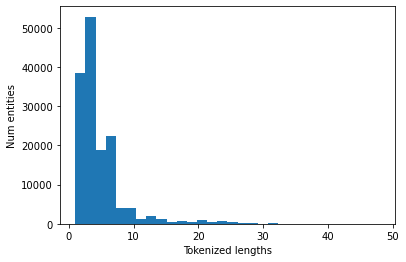

In [123]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

Text(0.5, 0, 'Tokenized lengths')

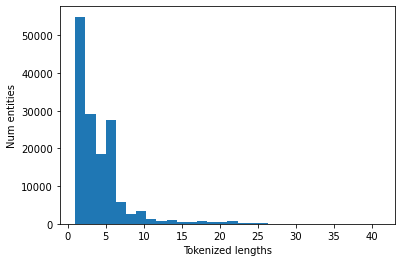

In [119]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

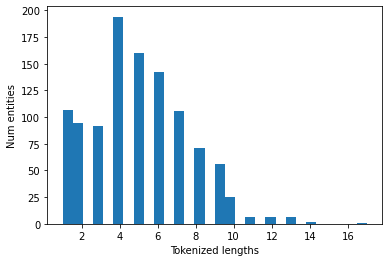

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)